SVM metrics: {'precision': 0.8703703703703703, 'recall': 0.8472222222222222, 'F1': 0.8447971781305115, 'accuracy': 0.8472222222222222}
confusion_matrix
[[26 10]
 [ 1 35]]
RF metrics: {'precision': 0.7453889334402566, 'recall': 0.7361111111111112, 'F1': 0.7335929892891918, 'accuracy': 0.7361111111111112}
confusion_matrix
[[23 13]
 [ 6 30]]
DT metrics: {'precision': 0.6428571428571428, 'recall': 0.6388888888888888, 'F1': 0.6363636363636362, 'accuracy': 0.6388888888888888}
confusion_matrix
[[20 16]
 [10 26]]


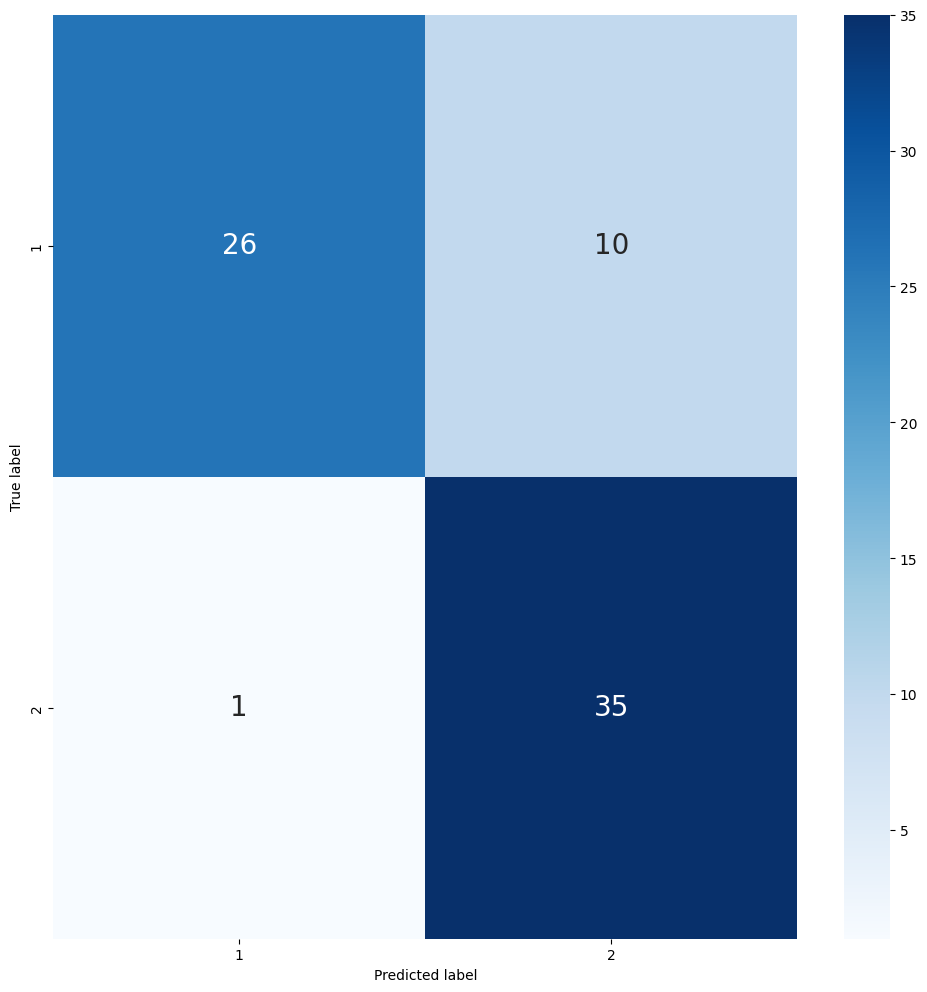

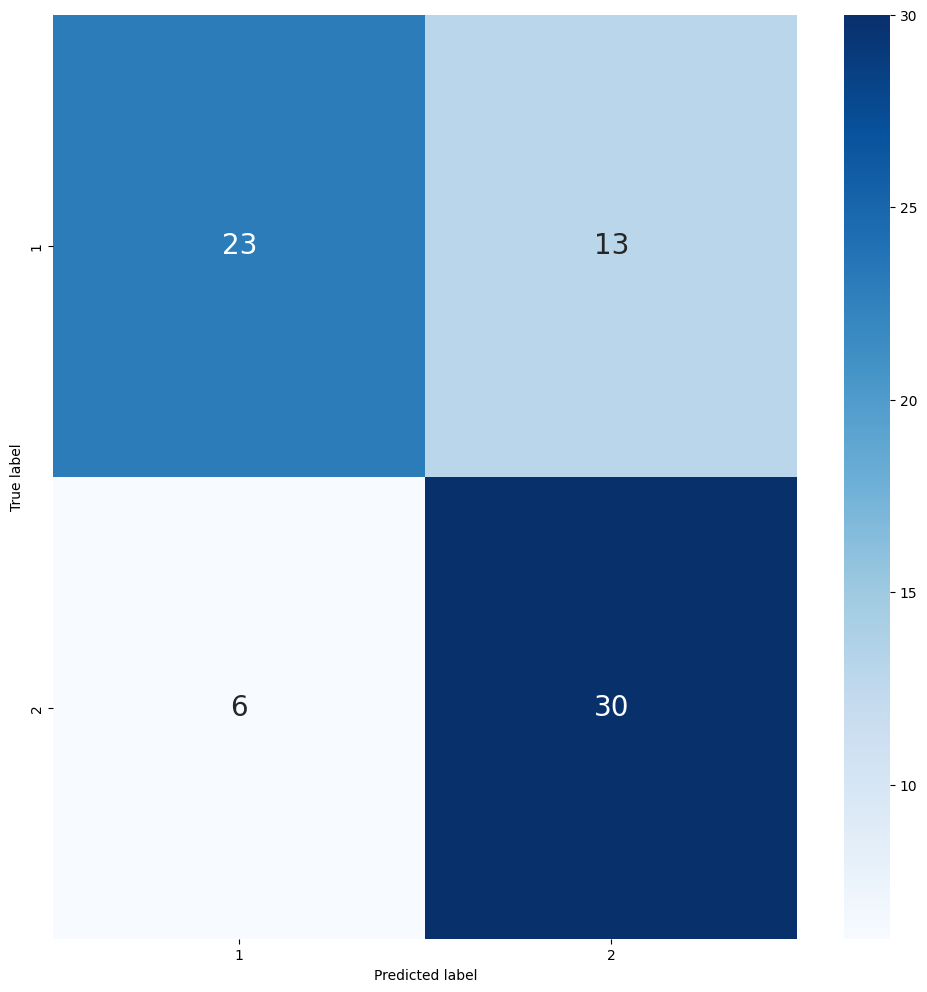

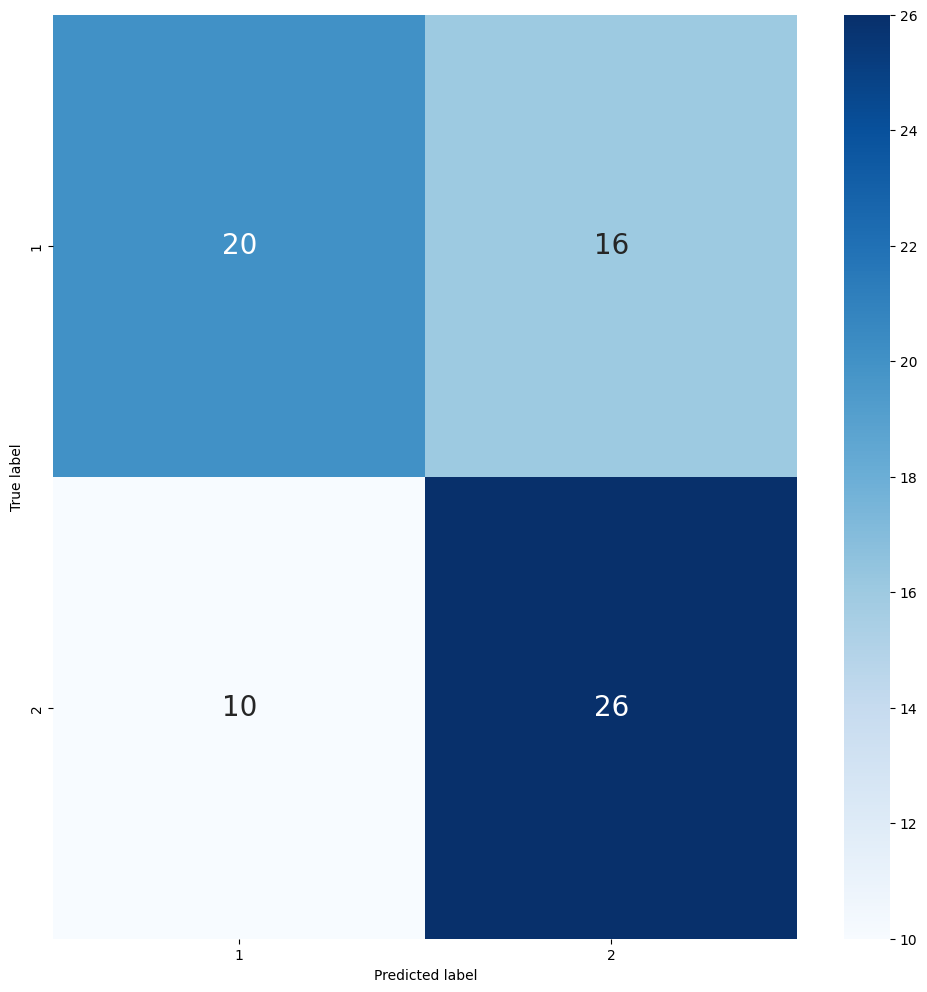

In [9]:
# Small HOG character,  pixels_per_cell=(16, 16),cells_per_block=(2, 2)
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage.feature import hog
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from skimage import io, color, transform
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import json

# Define directories
train_dir = './train/train/'
val_dir = './valid/valid/'

def load_annotations(json_file):
    with open(json_file, 'r') as file:
        annotations = json.load(file)

    # Convert annotations list to a DataFrame
    df_annotations = pd.DataFrame(annotations)

    # Convert bounding box format from (x_min, y_min, width, height) to (x_min, y_min, x_max, y_max)
    df_annotations['bbox'] = df_annotations.apply(lambda row: [row['bbox'][0], row['bbox'][1],
                                                               row['bbox'][0] + row['bbox'][2],
                                                               row['bbox'][1] + row['bbox'][3]], axis=1)

    return df_annotations

def extract_features_labels(directory_path, json_file):
    character_hog = []
    resized_imgs = []
    df = load_annotations(json_file)
    file_list = os.listdir(directory_path)
    sortedt_file_list = sorted(file_list)
    for filename in sortedt_file_list:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter for image files
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            resized_image = cv2.resize(image, (128, 128)) # resize the image to fit HOG descriptor

            resized_imgs.append(resized_image)  # Append resized image to the list
            character = hog(resized_image, orientations=9, pixels_per_cell=(16, 16),
                 cells_per_block=(2, 2), block_norm='L2', transform_sqrt=True)
            character_hog.append(character)
    labels = []
    bboxes = []
    for index, row in df.iterrows():
        labels.append(row['category_id'])
        bboxes.append(row['bbox'])
    return character_hog, resized_imgs, labels, bboxes  # Return resized_imgs as well


def model_type(X_train, y_train, model_type):
    if model_type == 'RF':
        m = RandomForestClassifier()
    elif model_type == 'SVM':
        #m = svm.SVC()
        m = svm.SVC(kernel='poly', C=1.0, gamma='scale')
    elif model_type == "DT":
        m = DecisionTreeClassifier()
    else:
        raise ValueError('Invalid model_type')
    m.fit(X_train, y_train)
    return m

def evaluate(y_test, y_pred):
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    accuracy = metrics.accuracy_score(y_test, y_pred)
    evaluation = {"precision": precision, "recall": recall, "F1": f1, "accuracy": accuracy}
    cm = confusion_matrix(y_test, y_pred)
    report = metrics.classification_report(y_test, y_pred)
    return evaluation , cm

def main():
    train_hogs, train_resized_images, train_labels, _ = extract_features_labels(train_dir, 'train_annotations')
    valid_hogs, valid_resized_images, valid_labels, valid_bboxes = extract_features_labels(val_dir, 'valid_annotations')

    model_types = ['SVM', 'RF',"DT"]
    for mt in model_types:
    # 使用 train_hogs 和 train_labels 训练模型
        modeld = model_type(train_hogs, train_labels, mt)
        y_pred = modeld.predict(valid_hogs)  # 使用 valid_hogs 预测
        metrics_dict, cm = evaluate(valid_labels, y_pred)
        print(f'{mt} metrics: {metrics_dict}')
        print("confusion_matrix")
        print(cm)
        cm = pd.DataFrame(cm, index=np.unique(valid_labels), columns=np.unique(valid_labels))
        cm.index.name = 'True label'
        cm.columns.name = 'Predicted label'
        fig, ax = plt.subplots(figsize=(12, 12))

        sns.heatmap(cm, cmap="Blues", annot=cm, fmt='', ax=ax,annot_kws={"size": 20},)

main()




SVM metrics: {'precision': 0.6875, 'recall': 0.6666666666666667, 'F1': 0.6571428571428571, 'accuracy': 0.6666666666666666}
confusion_matrix
[[18 18]
 [ 6 30]]
RF metrics: {'precision': 0.59375, 'recall': 0.5833333333333334, 'F1': 0.5714285714285714, 'accuracy': 0.5833333333333334}
confusion_matrix
[[15 21]
 [ 9 27]]


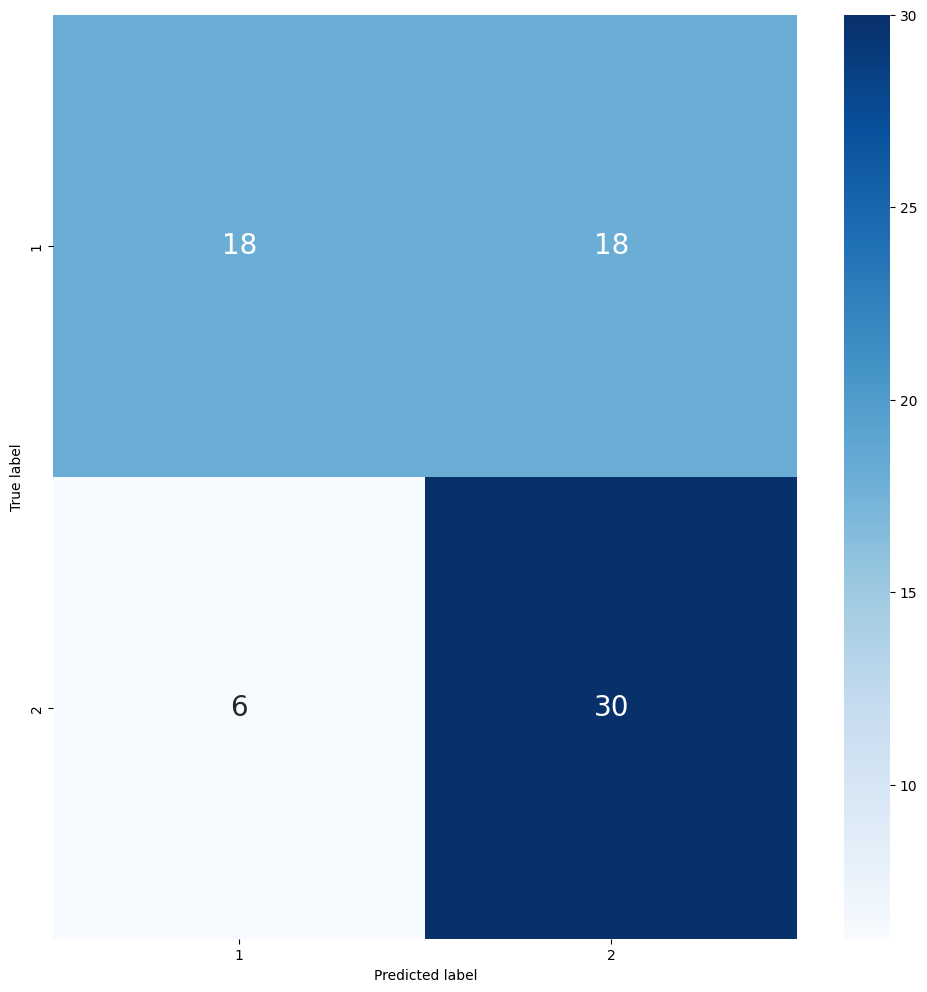

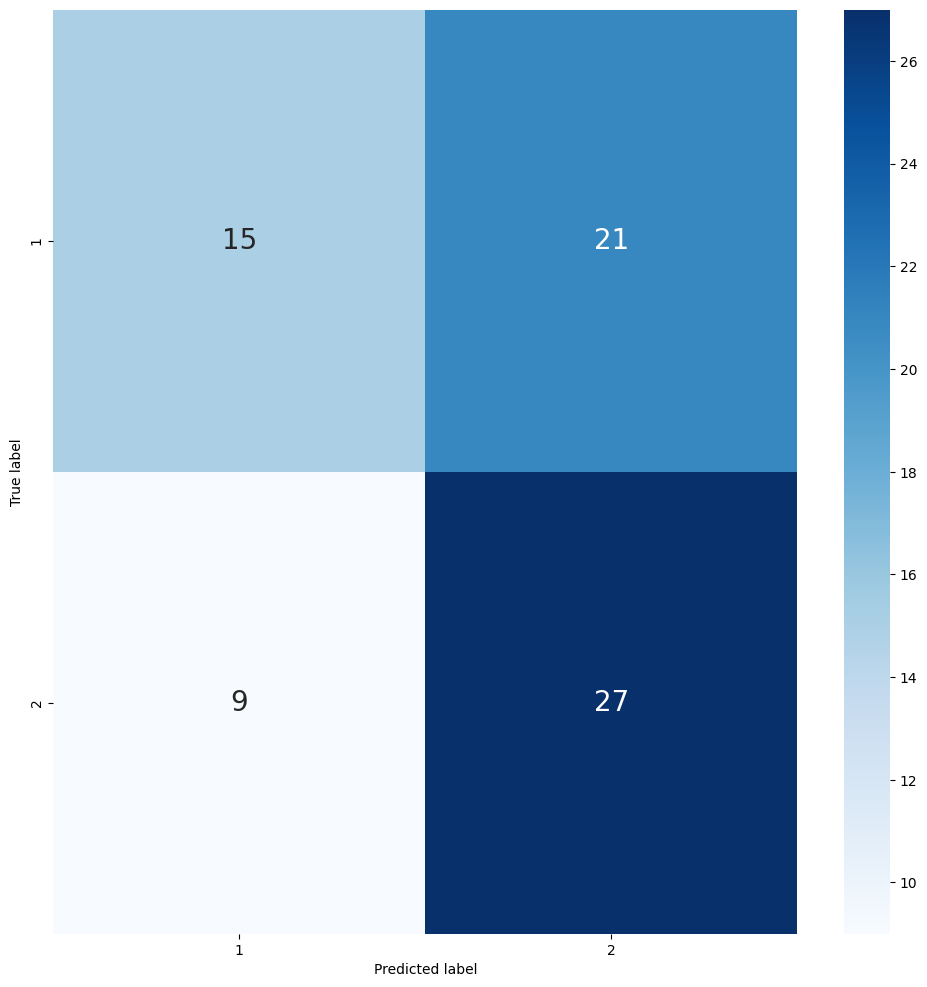

In [17]:
# Big HOG character, pixels_per_cell=(4, 4),cells_per_block=(4, 4)
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from skimage.feature import hog
from sklearn import svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from skimage import io, color, transform
import lightgbm as lgb
from sklearn.metrics import confusion_matrix
import json

# Define directories
train_dir = './train/train/'
val_dir = './valid/valid/'

def load_annotations(json_file):
    with open(json_file, 'r') as file:
        annotations = json.load(file)

    # Convert annotations list to a DataFrame
    df_annotations = pd.DataFrame(annotations)

    # Convert bounding box format from (x_min, y_min, width, height) to (x_min, y_min, x_max, y_max)
    df_annotations['bbox'] = df_annotations.apply(lambda row: [row['bbox'][0], row['bbox'][1],
                                                               row['bbox'][0] + row['bbox'][2],
                                                               row['bbox'][1] + row['bbox'][3]], axis=1)

    return df_annotations

def extract_features_labels(directory_path, json_file):
    character_hog = []
    resized_imgs = []
    df = load_annotations(json_file)
    file_list = os.listdir(directory_path)
    sortedt_file_list = sorted(file_list)
    for filename in sortedt_file_list:
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Filter for image files
            image_path = os.path.join(directory_path, filename)
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            resized_image = cv2.resize(image, (128, 128)) # resize the image to fit HOG descriptor

            resized_imgs.append(resized_image)  # Append resized image to the list
            character = hog(resized_image, orientations=9, pixels_per_cell=(4, 4),
                 cells_per_block=(4, 4), block_norm='L2', transform_sqrt=True)
            character_hog.append(character)
    labels = []
    bboxes = []
    for index, row in df.iterrows():
        labels.append(row['category_id'])
        bboxes.append(row['bbox'])
    return character_hog, resized_imgs, labels, bboxes  # Return resized_imgs as well


def model_type(X_train, y_train, model_type):
    if model_type == 'RF':
        m = RandomForestClassifier()
    elif model_type == 'SVM':
        #m = svm.SVC()
        m = svm.SVC(kernel='poly', C=1.0, gamma='scale')
    elif model_type == "DT":
        m = DecisionTreeClassifier()
    else:
        raise ValueError('Invalid model_type')
    m.fit(X_train, y_train)
    return m

def evaluate(y_test, y_pred):
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    accuracy = metrics.accuracy_score(y_test, y_pred)
    evaluation = {"precision": precision, "recall": recall, "F1": f1, "accuracy": accuracy}
    cm = confusion_matrix(y_test, y_pred)
    report = metrics.classification_report(y_test, y_pred)
    return evaluation , cm

def main():
    train_hogs, train_resized_images, train_labels, _ = extract_features_labels(train_dir, 'train_annotations')
    valid_hogs, valid_resized_images, valid_labels, valid_bboxes = extract_features_labels(val_dir, 'valid_annotations')

    model_types = ['SVM',"RF"]
    for mt in model_types:
    # 使用 train_hogs 和 train_labels 训练模型
        modeld = model_type(train_hogs, train_labels, mt)
        y_pred = modeld.predict(valid_hogs)  # 使用 valid_hogs 预测
        metrics_dict, cm = evaluate(valid_labels, y_pred)
        print(f'{mt} metrics: {metrics_dict}')
        print("confusion_matrix")
        print(cm)
        cm = pd.DataFrame(cm, index=np.unique(valid_labels), columns=np.unique(valid_labels))
        cm.index.name = 'True label'
        cm.columns.name = 'Predicted label'
        fig, ax = plt.subplots(figsize=(12, 12))

        sns.heatmap(cm, cmap="Blues", annot=cm, fmt='', ax=ax,annot_kws={"size": 20},)

main()

